#### Import Data

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
# from tool import model as md
from tool.blast import getblast
from tool import config as cfg
from sklearn.metrics import classification_report

from test import run
import pandas as pd
import os

dataset = pd.read_csv(cfg.DATA_PATH)
dataset = dataset.rename(columns={'Entry':'id','Sequence':'seq'})
train_data, vali_data = train_test_split(dataset, test_size=0.2, stratify=dataset['label'], random_state=42)
  
diamond_task = getblast(train = train_data, test = vali_data)
diamond_task

2024-03-04 12:35:14.001110: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-04 12:35:14.047157: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-04 12:35:14.047189: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-04 12:35:14.048690: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-04 12:35:14.056597: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-04 12:35:14.058198: I tensorflow/core/platform/cpu_feature_guard.cc:1

Write finished
Write finished
diamond makedb --in /tmp/train.fasta -d /tmp/train.dmnd --quiet


diamond v0.9.30.131 (C) Max Planck Society for the Advancement of Science
Documentation, support and updates available at http://www.diamondsearch.org



diamond blastp -d /tmp/train.dmnd  -q  /tmp/test.fasta -o /tmp/test_fasta_results.tsv -b5 -c1 -k 1 -e 1e-5 --quiet


diamond v0.9.30.131 (C) Max Planck Society for the Advancement of Science
Documentation, support and updates available at http://www.diamondsearch.org



,id,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore
0,Q74L27,Q045X9,97.6,499,12,0,1,499,1,499,2.100000e-286,982.6
1,Q65VB3,A6VLT3,88.3,480,56,0,1,480,1,480,7.900000e-254,874.4
2,A7NGC5,A5V230,76.2,235,55,1,1,234,1,235,3.400000e-93,339.7
3,D3S0H7,A0B870,60.2,186,74,0,1,186,1,186,6.800000e-60,228.8
4,B0KUL0,A5W794,98.3,362,6,0,1,362,1,362,9.300000e-207,717.6
...,...,...,...,...,...,...,...,...,...,...,...,...
18556,P0DC94,P0DC95,100.0,215,0,0,1,215,1,215,1.400000e-122,437.2
18557,P12602,P12601,98.6,281,4,0,1,281,1,281,2.400000e-157,553.1
18558,Q1I4H5,B1J1Y6,98.1,427,8,0,1,427,1,427,1.400000e-246,850.1
18559,B5E5S7,B8ZKX7,99.6,274,1,0,1,274,1,274,1.400000e-154,543.9


#### Evaluate

In [2]:
# 按照Query列分组，取每个组中最相似的记录
best_matches_df = diamond_task.loc[diamond_task.groupby('id')['bitscore'].idxmax()]
best_matches_df

,id,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore
11149,A0A024BTN9,Q6WP39,88.0,498,60,0,1,498,17,514,1.700000e-259,893.3
6395,A0A086F3E3,S5VBU1,35.4,127,74,2,4,122,5,131,1.200000e-16,85.1
2959,A0A0B5L585,F1DBB2,95.8,548,2,1,1,548,1,527,2.900000e-292,1002.3
3873,A0A0B6CGH9,A2A1A0,44.0,357,176,6,26,370,8,352,6.400000e-78,289.7
18315,A0A0C3RR82,P9WEM9,52.2,383,181,2,1,383,1,381,7.800000e-112,402.9
...,...,...,...,...,...,...,...,...,...,...,...,...
17224,U3KRG1,O57413,66.3,202,68,0,1,202,191,392,4.100000e-71,266.2
18063,U5PZ28,Q98UF9,78.1,484,105,1,1,483,1,484,1.500000e-223,773.9
17268,V5NC32,V5NDL4,76.7,596,138,1,5,600,1,595,1.700000e-274,943.3
12837,V5YM14,B2RID1,32.8,741,454,15,1,720,1,718,2.900000e-90,331.6


In [3]:
label_merge = pd.merge(best_matches_df,train_data[['id','label']], left_on="sseqid", right_on="id")
label_merge = pd.merge(label_merge,vali_data[['id','label']], left_on="id_x", right_on="id")
result = label_merge[['id_x', 'sseqid', 'pident', 'length', 'mismatch', 'gapopen',
       'qstart', 'qend', 'sstart', 'send', 'evalue',
       'bitscore','label_x', 'label_y']]
result.columns = ['Query', 'Subject', 'Identity', 'Length', 'Mismatches', 'Gaps',
       'Query_start', 'Query_end', 'Subject_start', 'Subject_end', 'E_value',
       'Bit_score','Predict', 'GroundTruth']
predict_miss = vali_data[vali_data.id.isin((set(vali_data.id)-set(result.Query)))][["id","label"]]
result

,Query,Subject,Identity,Length,Mismatches,Gaps,Query_start,Query_end,Subject_start,Subject_end,E_value,Bit_score,Predict,GroundTruth
0,A0A024BTN9,Q6WP39,88.0,498,60,0,1,498,17,514,1.700000e-259,893.3,2,1
1,P0C2D2,Q6WP39,90.2,61,6,0,1,61,19,79,3.600000e-26,115.2,2,2
2,P0C2D5,Q6WP39,96.7,30,1,0,1,30,19,48,4.600000e-11,63.9,2,1
3,Q90W54,Q6WP39,92.4,503,38,0,1,503,1,503,1.000000e-275,947.2,2,2
4,A0A086F3E3,S5VBU1,35.4,127,74,2,4,122,5,131,1.200000e-16,85.1,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18552,S5N020,Q9RUZ0,26.4,311,180,12,29,329,9,280,5.400000e-10,63.9,3,6
18553,U3KRG1,O57413,66.3,202,68,0,1,202,191,392,4.100000e-71,266.2,1,1
18554,U5PZ28,Q98UF9,78.1,484,105,1,1,483,1,484,1.500000e-223,773.9,1,2
18555,V5NC32,V5NDL4,76.7,596,138,1,5,600,1,595,1.700000e-274,943.3,1,1


In [4]:
groundtruth = np.concatenate([result["GroundTruth"].values,predict_miss.label.values])
predict = np.concatenate([result["Predict"].values,np.zeros(len(predict_miss))])

In [5]:
blast_report = pd.DataFrame(classification_report(groundtruth, predict, zero_division=0, output_dict=True)).T.iloc[1:,]
blast_report

,precision,recall,f1-score,support
1.0,0.983047,0.922365,0.951739,4212.000000
2.0,0.988885,0.955186,0.971743,10153.000000
3.0,0.978552,0.929936,0.953625,785.000000
4.0,0.978742,0.962963,0.970788,2295.000000
5.0,0.977941,0.943262,0.960289,141.000000
6.0,0.982688,0.975450,0.979055,1222.000000
7.0,1.000000,0.333333,0.500000,3.000000
8.0,0.960000,0.941176,0.950495,153.000000
10.0,0.995098,0.990244,0.992665,205.000000
12.0,0.988889,0.927083,0.956989,96.000000


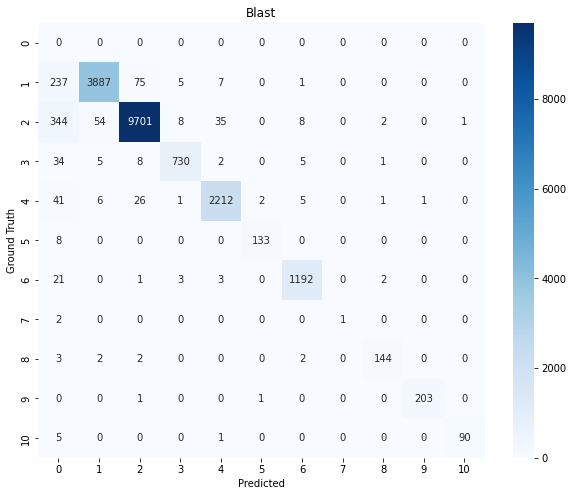

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 假设你有groundtruth和predict的数据
groundtruth = np.array(groundtruth)
predict = np.array(predict)

# 计算混淆矩阵
cm = confusion_matrix(groundtruth, predict)

# 使用seaborn库绘制热图
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Ground Truth')
plt.title('Blast')
plt.show()


### Identity Range

In [6]:
blast_columns = ["Query", "Subject", "Identity", "Length", "Mismatches", "Gaps", "Query_start", "Query_end", "Subject_start", "Subject_end", "E_value", "Bit_score"]
blast_df = pd.read_csv("blastp/output.txt", sep='\t', header=None, names=blast_columns)
blast_df

,Query,Subject,Identity,Length,Mismatches,Gaps,Query_start,Query_end,Subject_start,Subject_end,E_value,Bit_score
0,Q74L27,Q045X9,97.595,499,12,0,1,499,1,499,0.000,1013.0
1,Q74L27,A8YTD2,87.375,499,63,0,1,499,1,499,0.000,898.0
2,Q74L27,Q5FM35,86.974,499,65,0,1,499,1,499,0.000,895.0
3,Q74L27,Q1G8Y5,82.565,499,87,0,1,499,1,499,0.000,848.0
4,Q74L27,O86083,80.561,499,97,0,1,499,1,499,0.000,824.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6102392,B3CP03,Q8EB99,36.207,58,30,2,5,55,196,253,0.008,38.5
6102393,B3CP03,Q87ST2,33.333,60,33,1,5,57,218,277,0.028,37.0
6102394,B3CP03,Q6D0E4,36.735,49,24,2,21,62,241,289,0.240,33.9
6102395,B3CP03,Q65RA1,27.869,61,37,1,4,57,221,281,0.310,33.9


In [ ]:
blast_per30 = blast_df[blast_df["Identity"]<20]
test_dataset = dataset[dataset['uniprot_id'].isin(blast_per30.Query.unique())]
test_dataset

In [ ]:
label, predict = run(test_dataset)

2024-02-22 07:04:56.386582: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 19292 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:73:00.0, compute capability: 8.6
2024-02-22 07:04:56.900032: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


 1/44 [..............................] - ETA: 2:04

2024-02-22 07:05:00.369046: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700


44/44 [==============================] - 3s 4ms/step


In [ ]:
pd.DataFrame(classification_report(label, predict, zero_division=0, output_dict=True)).T

,precision,recall,f1-score,support
0,0.935622,0.931624,0.933619,234.000000
1,0.977038,0.988386,0.982679,861.000000
2,1.000000,0.915254,0.955752,59.000000
3,0.959302,0.948276,0.953757,174.000000
4,1.000000,0.894737,0.944444,19.000000
5,0.976190,0.976190,0.976190,42.000000
6,0.000000,0.000000,0.000000,3.000000
7,0.000000,0.000000,0.000000,7.000000
8,0.000000,0.000000,0.000000,0.000000
accuracy,0.962116,0.962116,0.962116,0.962116


In [2]:
import requests
# Get data from fasta 
url = "https://rest.uniprot.org/uniprotkb/P08499.fasta"

response = requests.get(url)

if response.status_code == 200:
    fasta_data = response.text
else:
    fasta_data = "Failed to download data. Status code: " + str(response.status_code)

header, *sequence_lines = fasta_data.split('\n')
uniprot_id = header.split('|')[1]
sequence = ''.join(sequence_lines)

data_fasta = pd.DataFrame({'uniprot_id': [uniprot_id], 'seq': [sequence]})

In [3]:
dataset = pd.read_csv(cfg.DATA_PATH)
dataset = dataset.rename(columns={'Entry':'id','Sequence':'seq'})
data_fasta = data_fasta.rename(columns={'uniprot_id':'id'})

# train_data, vali_data = train_test_split(dataset, test_size=0.2, stratify=dataset['label'], random_state=42)
diamond_task = getblast(train = dataset, test = data_fasta)
diamond_task

Write finished
Write finished
diamond makedb --in /tmp/train.fasta -d /tmp/train.dmnd --quiet


diamond v0.9.30.131 (C) Max Planck Society for the Advancement of Science
Documentation, support and updates available at http://www.diamondsearch.org



diamond blastp -d /tmp/train.dmnd  -q  /tmp/test.fasta -o /tmp/test_fasta_results.tsv -b5 -c1 -k 1 -e 1e-5 --quiet


diamond v0.9.30.131 (C) Max Planck Society for the Advancement of Science
Documentation, support and updates available at http://www.diamondsearch.org



,id,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore
0,P08499,Q5F8J4,39.9,436,243,7,19,443,4,431,1.700000e-74,278.9


In [4]:
dataset[dataset.id.isin(["Q5F8J4"])]

,id,seq,label,organism,EC number
20459,Q5F8J4,MKPVNIGLLGLGTVGGGAAAVLRDNAEEISRRLGREIRISAMCDLS...,4,Neisseria gonorrhoeae (strain ATCC 700825 / FA...,1.1.1.3
